# Fraud Detection - Exploratory Data Analysis

This Jupyter Notebook performs exploratory data analysis (EDA) for the fraud detection project at Adey Innovations Inc., focusing on e-commerce (`Fraud_Data.csv`) and credit card (`creditcard.csv`) transaction datasets, with IP-to-country mapping (`IpAddress_to_Country.csv`). It fulfills the requirements for **Interim Submission 1** due on July 20, 2025.

## Objectives:
1. Load and inspect the datasets.
2. Clean and preprocess data (handle missing values, duplicates, outliers).
3. Analyze class distribution and propose strategies for class imbalance.
4. Perform feature engineering (`time_since_signup`, IP-to-country mapping).
5. Visualize key patterns and relationships.
6. Summarize insights for modeling and business context.

In [1]:
# Import Libraries
# ----------------
# This cell imports all necessary libraries for data manipulation, visualization, and IP address processing.
# We create a results directory to store visualizations and insights.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import ipaddress
import os
import json

# Configure display and plotting styles
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Create results directory
if not os.path.exists('../results'):
    os.makedirs('../results')

## 1. Data Loading

This section loads the three datasets: `Fraud_Data.csv` (e-commerce transactions), `IpAddress_to_Country.csv` (IP-to-country mapping), and `creditcard.csv` (credit card transactions). We inspect their shapes and basic structure to understand the data.

In [2]:
# Load datasets
fraud_data = pd.read_csv('../Data/Fraud_Data.csv')
ip_country = pd.read_csv('../Data/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv('../Data/creditcard.csv')

# Display dataset shapes
print("Dataset shapes:")
print(f"Fraud Data: {fraud_data.shape}")
print(f"IP to Country: {ip_country.shape}")
print(f"Credit Card Data: {creditcard_data.shape}")

# Display sample rows
print("\n=== FRAUD DATA SAMPLE ===")
print(fraud_data.head())
print("\n=== IP TO COUNTRY SAMPLE ===")
print(ip_country.head())
print("\n=== CREDIT CARD DATA SAMPLE ===")
print(creditcard_data.head())

Dataset shapes:
Fraud Data: (151112, 11)
IP to Country: (138846, 3)
Credit Card Data: (284807, 31)

=== FRAUD DATA SAMPLE ===
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  

=== IP TO COUNTRY SAMPLE ===
   lower_bound_ip_address  

## 2. Data Quality Assessment

We check for missing values, duplicates, and outliers to ensure data quality. Missing values are imputed, duplicates are removed, and outliers are capped using the IQR method.

In [3]:
# Check for missing values
print("=== MISSING VALUES ANALYSIS ===")
print("\nFraud Data Missing Values:")
fraud_missing = fraud_data.isnull().sum()
fraud_missing_pct = (fraud_missing / len(fraud_data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': fraud_missing,
    'Missing Percentage': fraud_missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\nCredit Card Data Missing Values:")
cc_missing = creditcard_data.isnull().sum()
cc_missing_pct = (cc_missing / len(creditcard_data)) * 100
cc_missing_df = pd.DataFrame({
    'Missing Count': cc_missing,
    'Missing Percentage': cc_missing_pct
})
print(cc_missing_df[cc_missing_df['Missing Count'] > 0])

# Handle missing values
if fraud_missing.sum() > 0:
    fraud_data.fillna({
        'source': fraud_data['source'].mode()[0],
        'browser': fraud_data['browser'].mode()[0],
        'sex': fraud_data['sex'].mode()[0],
        'age': fraud_data['age'].median(),
        'purchase_value': fraud_data['purchase_value'].median()
    }, inplace=True)
    print("\nMissing values imputed for Fraud Data.")

=== MISSING VALUES ANALYSIS ===

Fraud Data Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

Credit Card Data Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []


In [4]:
# Check for duplicates
print("=== DUPLICATE ANALYSIS ===")
fraud_duplicates = fraud_data.duplicated().sum()
cc_duplicates = creditcard_data.duplicated().sum()
ip_duplicates = ip_country.duplicated().sum()
print(f"Fraud Data Duplicates: {fraud_duplicates}")
print(f"Credit Card Data Duplicates: {cc_duplicates}")
print(f"IP Country Data Duplicates: {ip_duplicates}")

# Remove duplicates
if fraud_duplicates > 0:
    fraud_data = fraud_data.drop_duplicates()
    print(f"Removed {fraud_duplicates} duplicates from Fraud Data.")
if cc_duplicates > 0:
    creditcard_data = creditcard_data.drop_duplicates()
    print(f"Removed {cc_duplicates} duplicates from Credit Card Data.")

=== DUPLICATE ANALYSIS ===
Fraud Data Duplicates: 0
Credit Card Data Duplicates: 1081
IP Country Data Duplicates: 0
Removed 1081 duplicates from Credit Card Data.


In [5]:
# Outlier detection using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers), lower_bound, upper_bound

# Fraud Data: purchase_value and age
pv_outliers, pv_lower, pv_upper = detect_outliers(fraud_data, 'purchase_value')
age_outliers, age_lower, age_upper = detect_outliers(fraud_data, 'age')
print("=== OUTLIER ANALYSIS (Fraud Data) ===")
print(f"Purchase Value Outliers: {pv_outliers} (Bounds: [{pv_lower:.2f}, {pv_upper:.2f}])")
print(f"Age Outliers: {age_outliers} (Bounds: [{age_lower:.2f}, {age_upper:.2f}])")

# Credit Card Data: Amount
amt_outliers, amt_lower, amt_upper = detect_outliers(creditcard_data, 'Amount')
print("\n=== OUTLIER ANALYSIS (Credit Card Data) ===")
print(f"Amount Outliers: {amt_outliers} (Bounds: [{amt_lower:.2f}, {amt_upper:.2f}])")

# Cap outliers
fraud_data['purchase_value'] = fraud_data['purchase_value'].clip(lower=pv_lower, upper=pv_upper)
fraud_data['age'] = fraud_data['age'].clip(lower=age_lower, upper=age_upper)
creditcard_data['Amount'] = creditcard_data['Amount'].clip(lower=amt_lower, upper=amt_upper)
print("\nOutliers capped for numerical features.")

=== OUTLIER ANALYSIS (Fraud Data) ===
Purchase Value Outliers: 1067 (Bounds: [-18.50, 89.50])
Age Outliers: 776 (Bounds: [9.00, 57.00])

=== OUTLIER ANALYSIS (Credit Card Data) ===
Amount Outliers: 31685 (Bounds: [-102.27, 185.38])

Outliers capped for numerical features.


## 3. Class Distribution Analysis

We analyze the class distribution in both datasets to quantify the imbalance between legitimate (0) and fraudulent (1) transactions. An interactive Chart.js visualization is generated for the report.

In [6]:
# Analyze class distribution
print("=== CLASS DISTRIBUTION ANALYSIS ===")

# Fraud data
fraud_class_dist = fraud_data['class'].value_counts()
fraud_class_pct = fraud_data['class'].value_counts(normalize=True) * 100

print("Fraud Data Class Distribution:")
print(f"Legitimate (0): {fraud_class_dist[0]:,} ({fraud_class_pct[0]:.2f}%)")
print(f"Fraudulent (1): {fraud_class_dist[1]:,} ({fraud_class_pct[1]:.2f}%)")
print(f"Imbalance Ratio: {fraud_class_dist[0]/fraud_class_dist[1]:.1f}:1")

# Credit card data
cc_class_dist = creditcard_data['Class'].value_counts()
cc_class_pct = creditcard_data['Class'].value_counts(normalize=True) * 100

print("\nCredit Card Data Class Distribution:")
print(f"Legitimate (0): {cc_class_dist[0]:,} ({cc_class_pct[0]:.2f}%)")
print(f"Fraudulent (1): {cc_class_dist[1]:,} ({cc_class_pct[1]:.2f}%)")
print(f"Imbalance Ratio: {cc_class_dist[0]/cc_class_dist[1]:.1f}:1")

=== CLASS DISTRIBUTION ANALYSIS ===
Fraud Data Class Distribution:
Legitimate (0): 136,961 (90.64%)
Fraudulent (1): 14,151 (9.36%)
Imbalance Ratio: 9.7:1

Credit Card Data Class Distribution:
Legitimate (0): 283,253 (99.83%)
Fraudulent (1): 473 (0.17%)
Imbalance Ratio: 598.8:1


In [7]:
chart_data = {
    'type': 'bar',
    'data': {
        'labels': ['Legitimate (0)', 'Fraudulent (1)'],
        'datasets': [
            {
                'label': 'E-commerce Fraud Data',
                'data': [int(fraud_class_dist[0]), int(fraud_class_dist[1])],
                'backgroundColor': ['#36A2EB', '#FF6384'],
                'borderColor': ['#36A2EB', '#FF6384'],
                'borderWidth': 1
            },
            {
                'label': 'Credit Card Data',
                'data': [int(cc_class_dist[0]), int(cc_class_dist[1])],
                'backgroundColor': ['#4BC0C0', '#FF9F40'],
                'borderColor': ['#4BC0C0', '#FF9F40'],
                'borderWidth': 1
            }
        ]
    },
    'options': {
        'scales': {
            'y': {
                'beginAtZero': True,
                'title': {
                    'display': True,
                    'text': 'Count'
                }
            },
            'x': {
                'title': {
                    'display': True,
                    'text': 'Class'
                }
            }
        },
        'plugins': {
            'title': {
                'display': True,
                'text': 'Class Distribution for E-commerce and Credit Card Data'
            },
            'legend': {
                'display': True
            }
        }
    }
}

with open('../results/class_distribution_chart.json', 'w') as f:
    json.dump(chart_data, f)

print("Class distribution chart saved to results/class_distribution_chart.json")


Class distribution chart saved to results/class_distribution_chart.json


## 4. Fraud Data Analysis

This section explores the e-commerce dataset (`Fraud_Data.csv`), analyzing numerical features (`purchase_value`, `age`) and categorical features (`source`, `browser`, `sex`). We visualize distributions and fraud rates to identify patterns.

In [8]:
# Statistical summary
print("=== FRAUD DATA STATISTICAL SUMMARY ===")
print(fraud_data.describe())

=== FRAUD DATA STATISTICAL SUMMARY ===
             user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.878828      33.122975  2.152145e+09   
std    115369.285024       18.136443       8.562713  1.248497e+09   
min         2.000000        9.000000      18.000000  5.209350e+04   
25%    100642.500000       22.000000      27.000000  1.085934e+09   
50%    199958.000000       35.000000      33.000000  2.154770e+09   
75%    300054.000000       49.000000      39.000000  3.243258e+09   
max    400000.000000       89.500000      57.000000  4.294850e+09   

               class  
count  151112.000000  
mean        0.093646  
std         0.291336  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


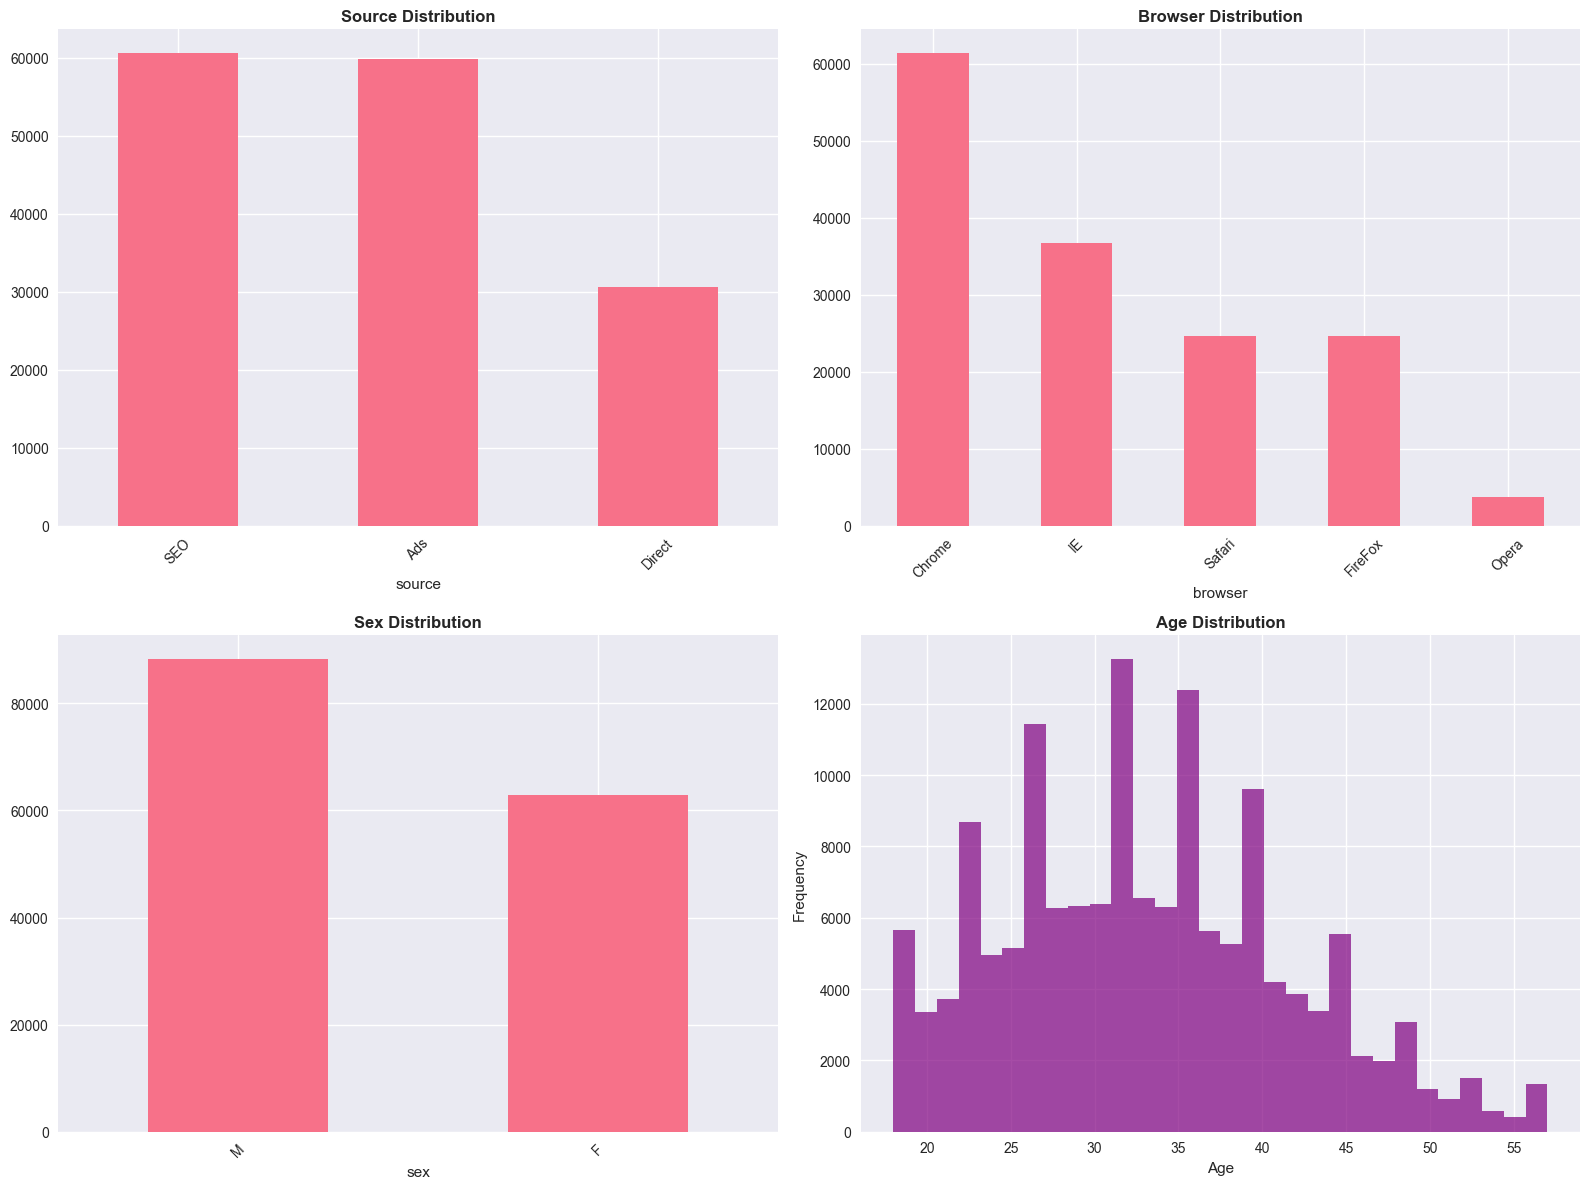

In [9]:
# Categorical feature distributions
categorical_features = ['source', 'browser', 'sex']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    fraud_data[feature].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{feature.title()} Distribution', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)

# Age distribution
fraud_data['age'].hist(bins=30, ax=axes[3], alpha=0.7, color='purple')
axes[3].set_title('Age Distribution', fontweight='bold')
axes[3].set_xlabel('Age')
axes[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../results/fraud_categorical_distributions.png')
plt.show()

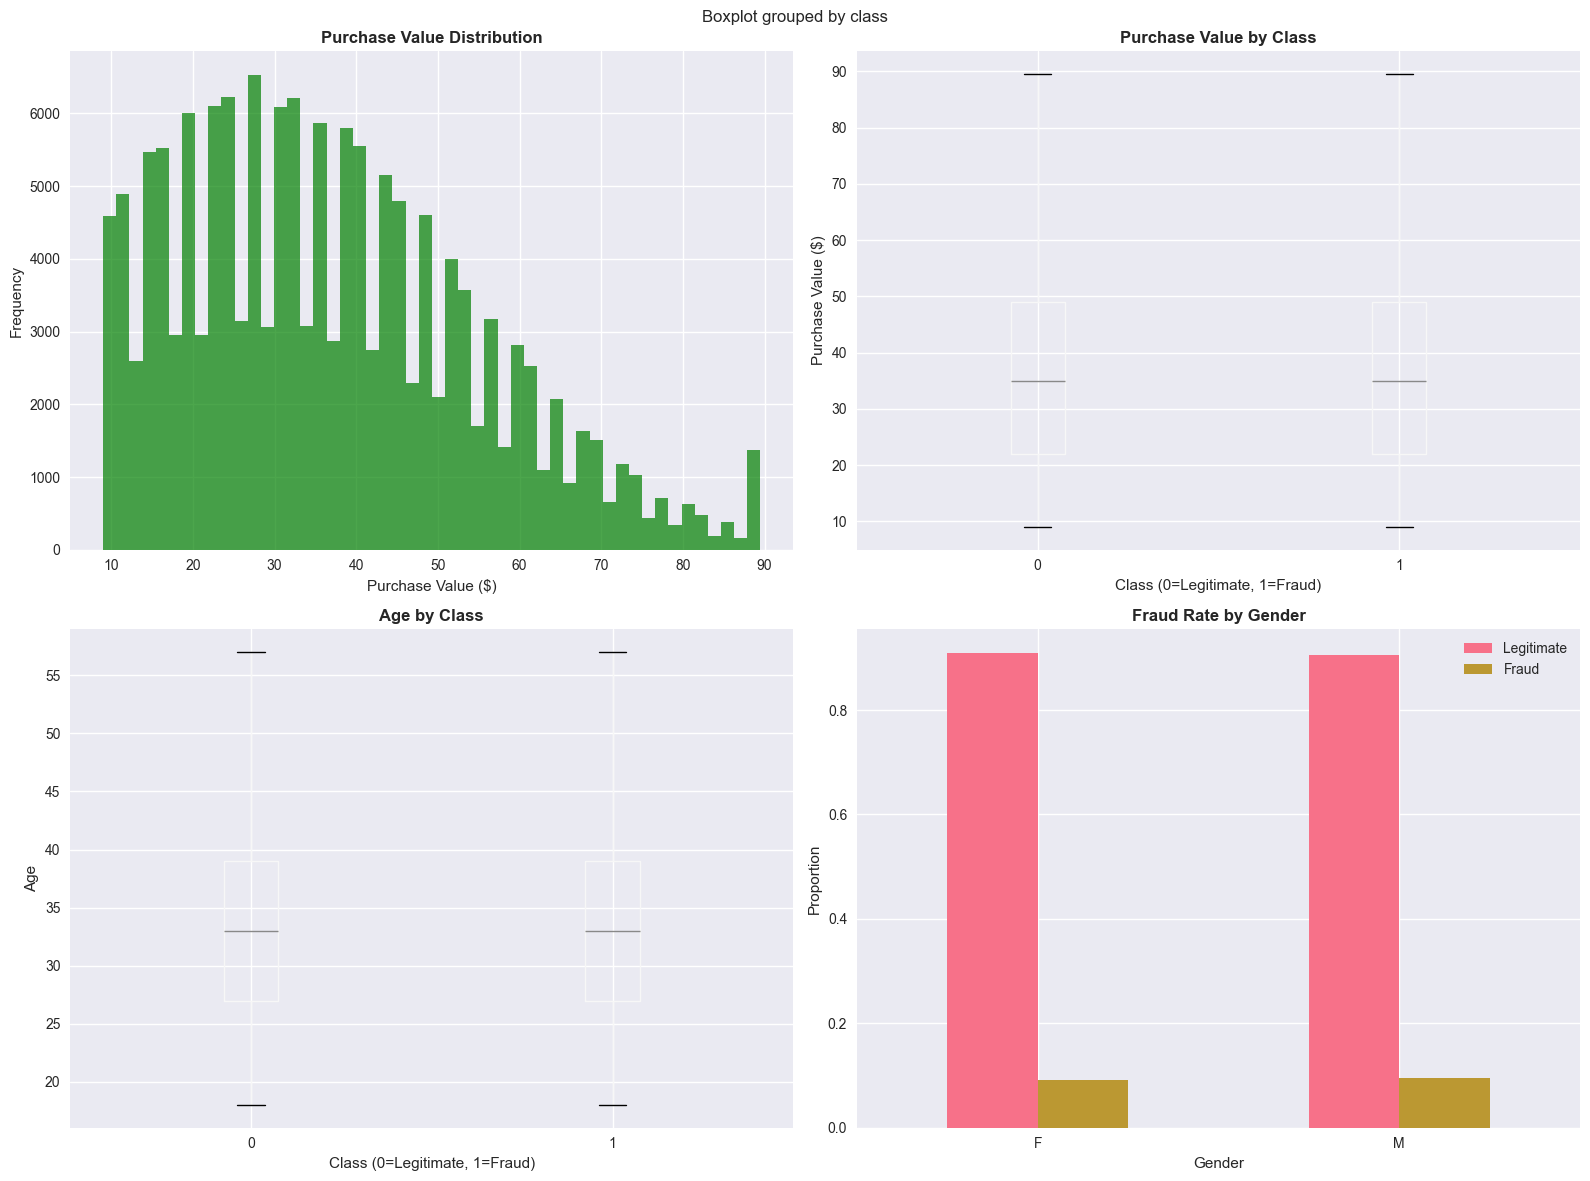

In [10]:
# Purchase patterns and fraud rates
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Purchase value distribution
fraud_data['purchase_value'].hist(bins=50, ax=axes[0,0], alpha=0.7, color='green')
axes[0,0].set_title('Purchase Value Distribution', fontweight='bold')
axes[0,0].set_xlabel('Purchase Value ($)')
axes[0,0].set_ylabel('Frequency')

# Purchase value by class
fraud_data.boxplot(column='purchase_value', by='class', ax=axes[0,1])
axes[0,1].set_title('Purchase Value by Class', fontweight='bold')
axes[0,1].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[0,1].set_ylabel('Purchase Value ($)')

# Age by class
fraud_data.boxplot(column='age', by='class', ax=axes[1,0])
axes[1,0].set_title('Age by Class', fontweight='bold')
axes[1,0].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[1,0].set_ylabel('Age')

# Fraud rate by gender
pd.crosstab(fraud_data['sex'], fraud_data['class'], normalize='index').plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Fraud Rate by Gender', fontweight='bold')
axes[1,1].set_xlabel('Gender')
axes[1,1].set_ylabel('Proportion')
axes[1,1].legend(['Legitimate', 'Fraud'])
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../results/fraud_purchase_patterns.png')
plt.show()

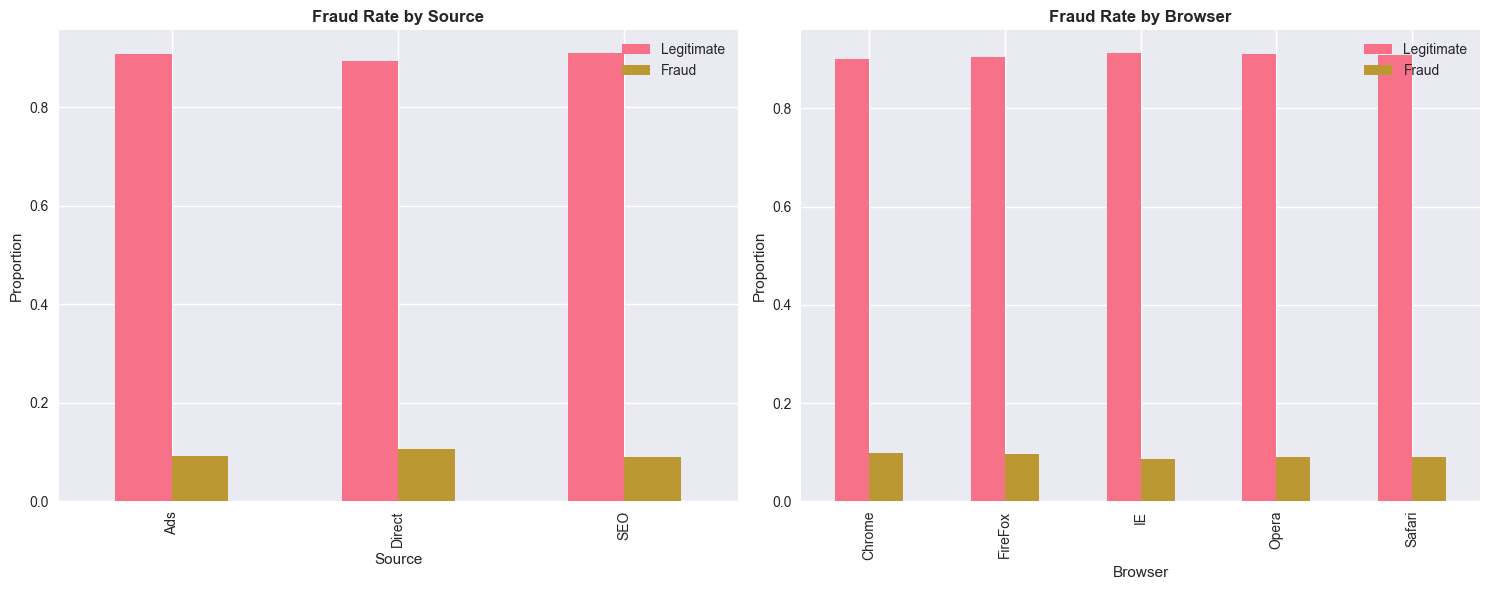

In [11]:
# Fraud rate by source and browser
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
pd.crosstab(fraud_data['source'], fraud_data['class'], normalize='index').plot(kind='bar', ax=axes[0])
axes[0].set_title('Fraud Rate by Source', fontweight='bold')
axes[0].set_xlabel('Source')
axes[0].set_ylabel('Proportion')
axes[0].legend(['Legitimate', 'Fraud'])

pd.crosstab(fraud_data['browser'], fraud_data['class'], normalize='index').plot(kind='bar', ax=axes[1])
axes[1].set_title('Fraud Rate by Browser', fontweight='bold')
axes[1].set_xlabel('Browser')
axes[1].set_ylabel('Proportion')
axes[1].legend(['Legitimate', 'Fraud'])

plt.tight_layout()
plt.savefig('../results/fraud_source_browser.png')
plt.show()

## 5. Credit Card Data Analysis

We analyze the credit card dataset (`creditcard.csv`), focusing on `Amount`, `Time`, and PCA features (`V1`–`V28`). Distributions and correlations with the `Class` variable are visualized.

In [12]:
# Statistical summary
print("=== CREDIT CARD DATA STATISTICAL SUMMARY ===")
print(creditcard_data.describe())

=== CREDIT CARD DATA STATISTICAL SUMMARY ===
                Time             V1             V2             V3  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean    94811.077600       0.005917      -0.004135       0.001613   
std     47481.047891       1.948026       1.646703       1.508682   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54204.750000      -0.915951      -0.600321      -0.889682   
50%     84692.500000       0.020384       0.063949       0.179963   
75%    139298.000000       1.316068       0.800283       1.026960   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean       -0.002966       0.001828      -0.001139       0.001801   
std         1.414184       1.377008       1.331931       1.227664   
min        -5.683171    -113.743307     -26.160506     -4

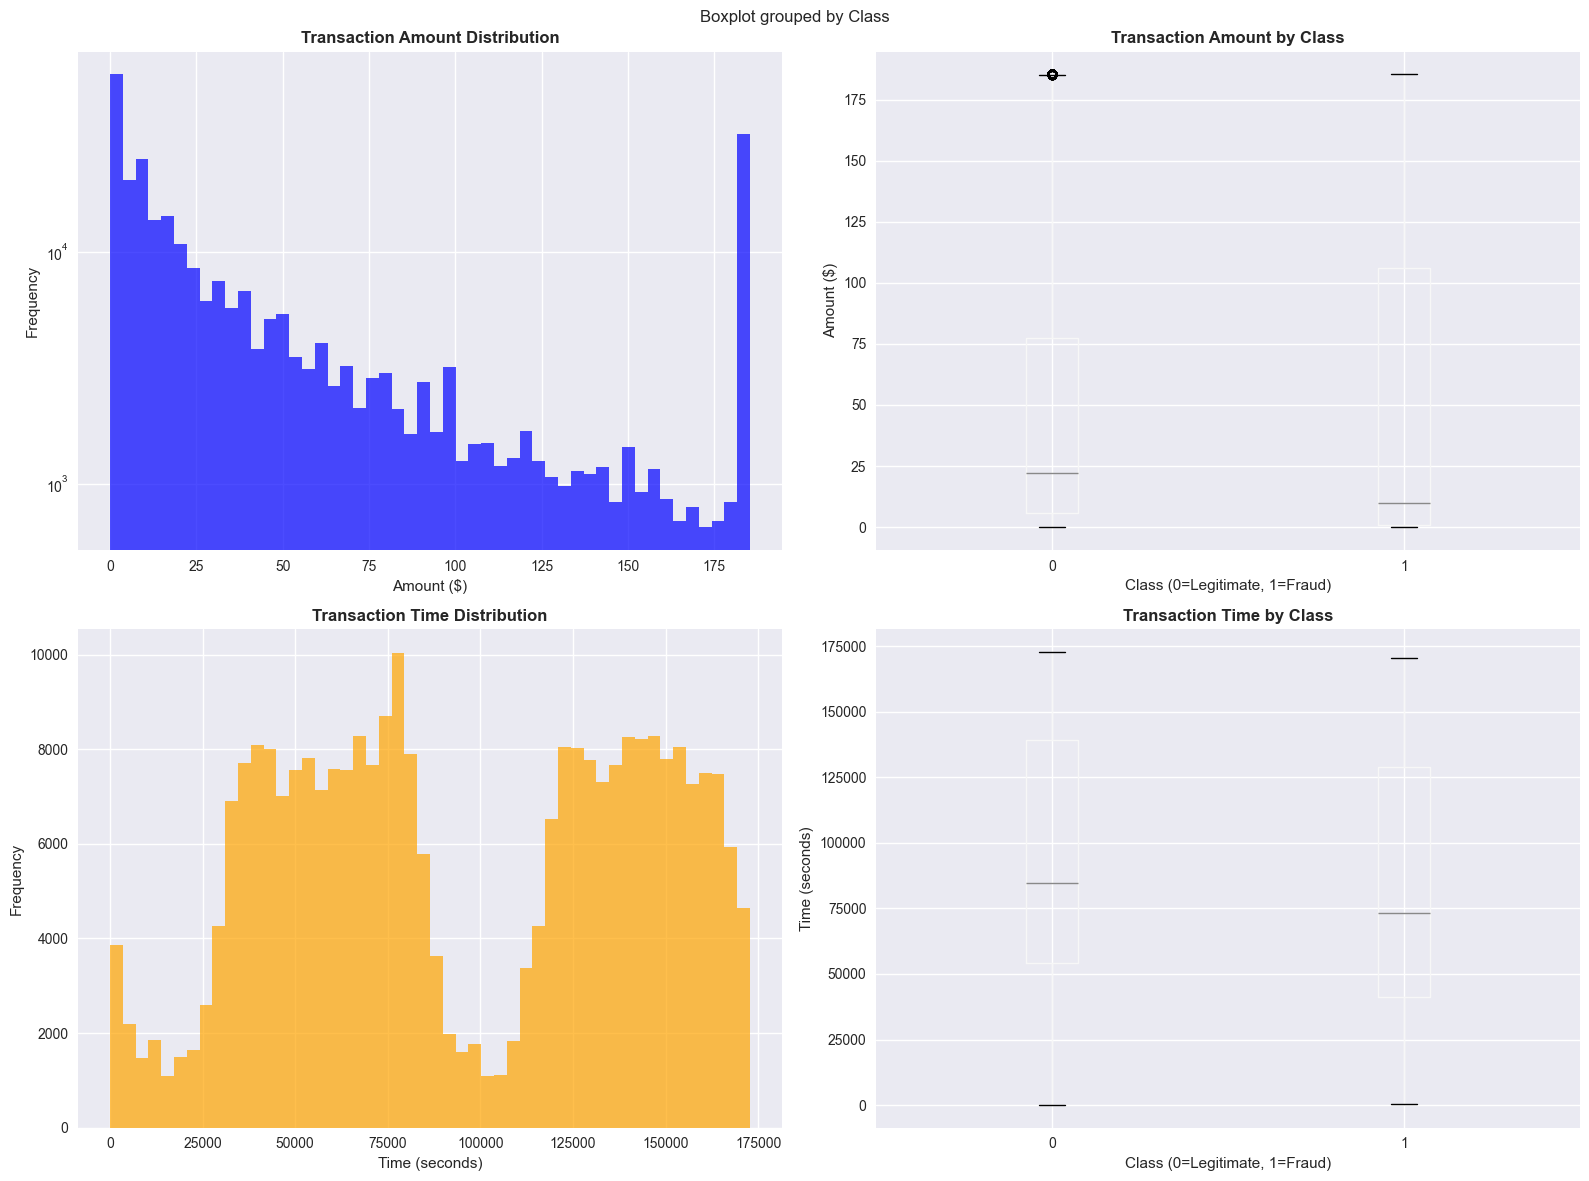

In [13]:
# Transaction amount and time analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Amount distribution (log scale)
creditcard_data['Amount'].hist(bins=50, ax=axes[0,0], alpha=0.7, color='blue')
axes[0,0].set_title('Transaction Amount Distribution', fontweight='bold')
axes[0,0].set_xlabel('Amount ($)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_yscale('log')

# Amount by class
creditcard_data.boxplot(column='Amount', by='Class', ax=axes[0,1])
axes[0,1].set_title('Transaction Amount by Class', fontweight='bold')
axes[0,1].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[0,1].set_ylabel('Amount ($)')

# Time distribution
creditcard_data['Time'].hist(bins=50, ax=axes[1,0], alpha=0.7, color='orange')
axes[1,0].set_title('Transaction Time Distribution', fontweight='bold')
axes[1,0].set_xlabel('Time (seconds)')
axes[1,0].set_ylabel('Frequency')

# Time by class
creditcard_data.boxplot(column='Time', by='Class', ax=axes[1,1])
axes[1,1].set_title('Transaction Time by Class', fontweight='bold')
axes[1,1].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[1,1].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.savefig('../results/creditcard_patterns.png')
plt.show()

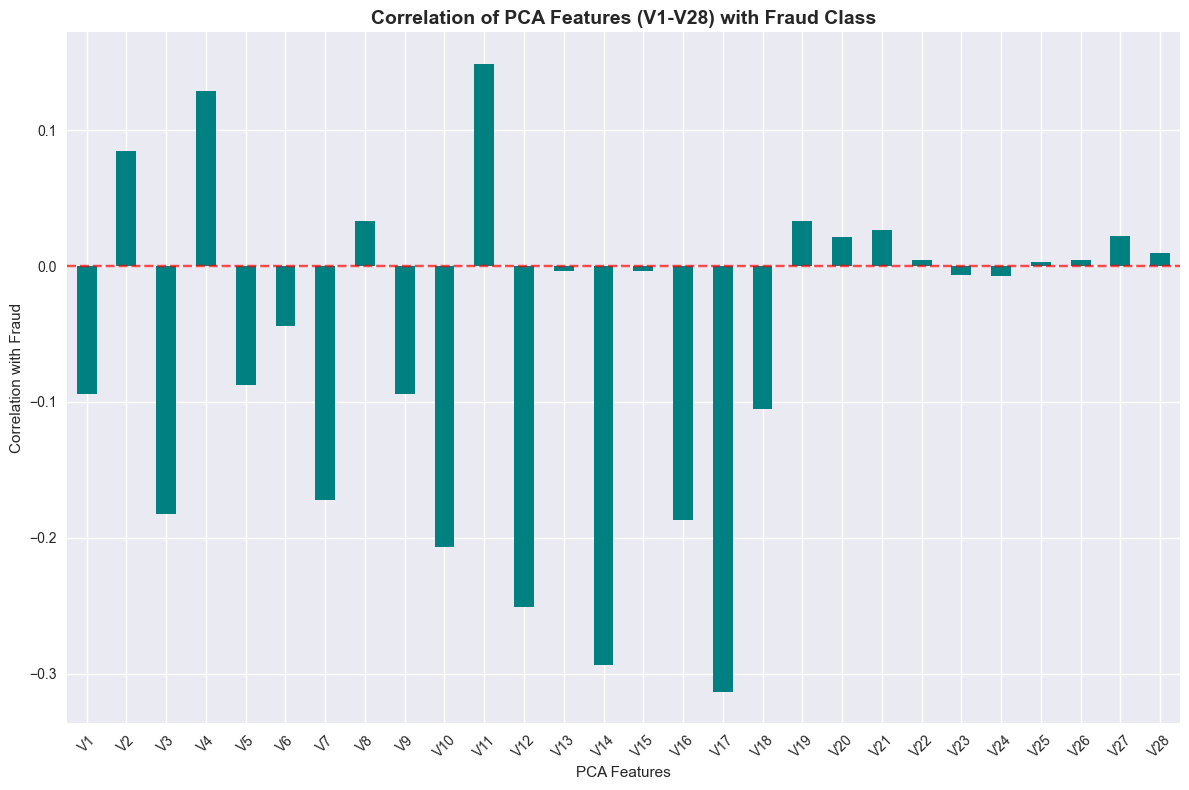

Top 10 PCA features most correlated with fraud:
V17    0.313498
V14    0.293375
V12    0.250711
V10    0.206971
V16    0.187186
V3     0.182322
V7     0.172347
V11    0.149067
V4     0.129326
V18    0.105340
Name: Class, dtype: float64


In [14]:
# PCA feature correlation with fraud
v_features = [col for col in creditcard_data.columns if col.startswith('V')]
correlations = creditcard_data[v_features + ['Class']].corr()['Class'].drop('Class')

# Plot correlation
plt.figure(figsize=(12, 8))
correlations.plot(kind='bar', color='teal')
plt.title('Correlation of PCA Features (V1-V28) with Fraud Class', fontweight='bold', fontsize=14)
plt.xlabel('PCA Features')
plt.ylabel('Correlation with Fraud')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../results/creditcard_pca_correlations.png')
plt.show()

# Top correlated features
print("Top 10 PCA features most correlated with fraud:")
print(correlations.abs().sort_values(ascending=False).head(10))

## 6. Feature Engineering: Time-Based Features

We engineer time-based features for `Fraud_Data.csv`, including `time_since_signup` (difference between `purchase_time` and `signup_time`) and temporal features (`purchase_hour`, `purchase_weekday`). These are visualized to identify fraud patterns.

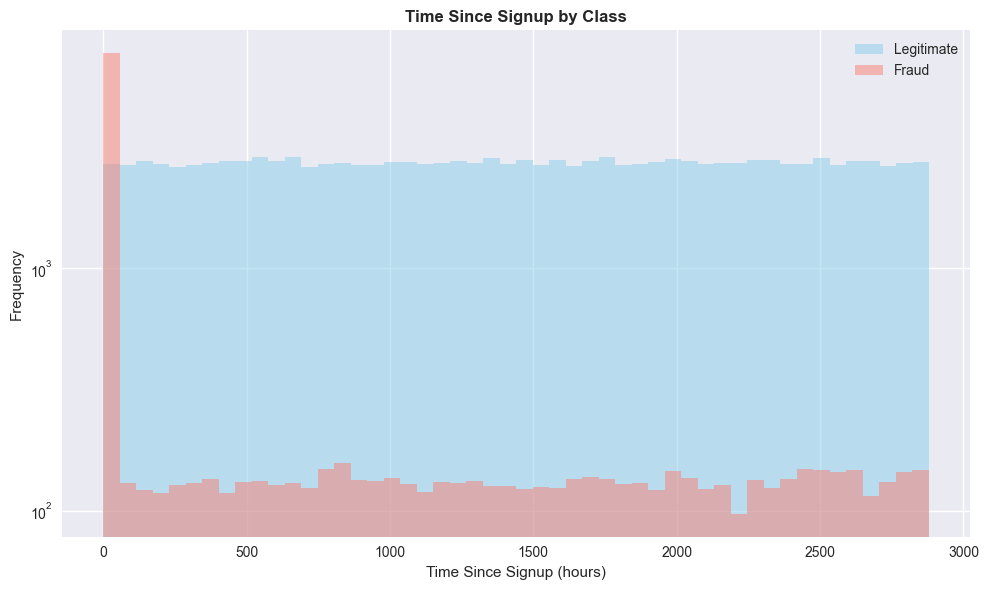

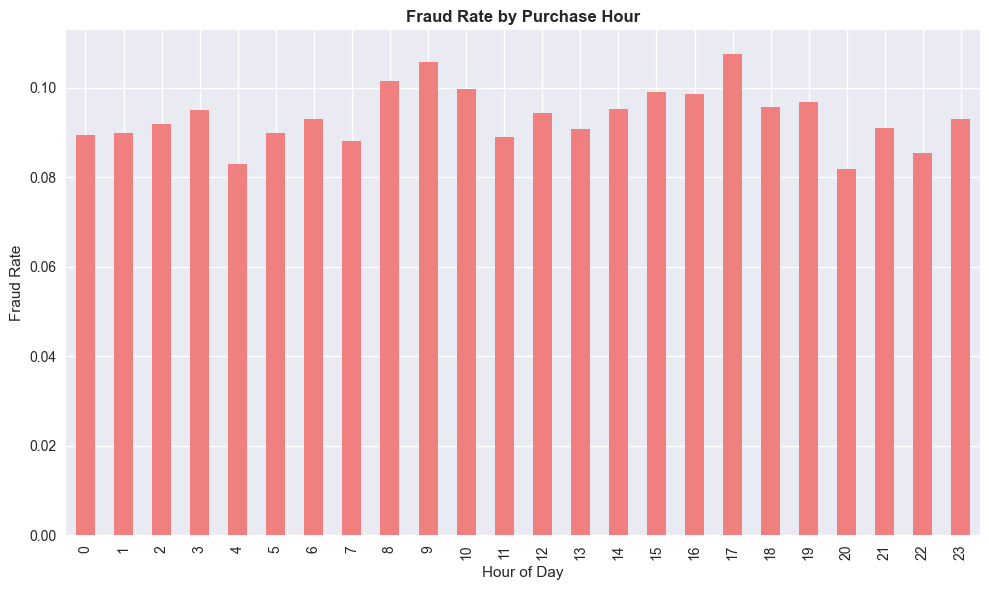

In [15]:
# Convert timestamps
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Calculate time_since_signup (hours)
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

# Extract hour and weekday
fraud_data['purchase_hour'] = fraud_data['purchase_time'].dt.hour
fraud_data['purchase_weekday'] = fraud_data['purchase_time'].dt.weekday

# Visualize time_since_signup by class
plt.figure(figsize=(10, 6))
fraud_data[fraud_data['class'] == 0]['time_since_signup'].hist(bins=50, alpha=0.5, label='Legitimate', color='skyblue')
fraud_data[fraud_data['class'] == 1]['time_since_signup'].hist(bins=50, alpha=0.5, label='Fraud', color='salmon')
plt.title('Time Since Signup by Class', fontweight='bold')
plt.xlabel('Time Since Signup (hours)')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.savefig('../results/time_since_signup.png')
plt.show()

# Fraud rate by purchase hour
plt.figure(figsize=(10, 6))
fraud_data.groupby('purchase_hour')['class'].mean().plot(kind='bar', color='lightcoral')
plt.title('Fraud Rate by Purchase Hour', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.savefig('../results/fraud_rate_by_hour.png')
plt.show()

## 7. Feature Engineering: Geolocation Analysis

We map IP addresses from `Fraud_Data.csv` to countries using `IpAddress_to_Country.csv`. Fraud rates by country are analyzed to identify high-risk regions.

Country mapping completed. Sample rows:
     ip_address  country
0  7.327584e+08  Unknown
1  3.503114e+08  Unknown
2  2.621474e+09  Unknown
3  3.840542e+09  Unknown
4  4.155831e+08  Unknown


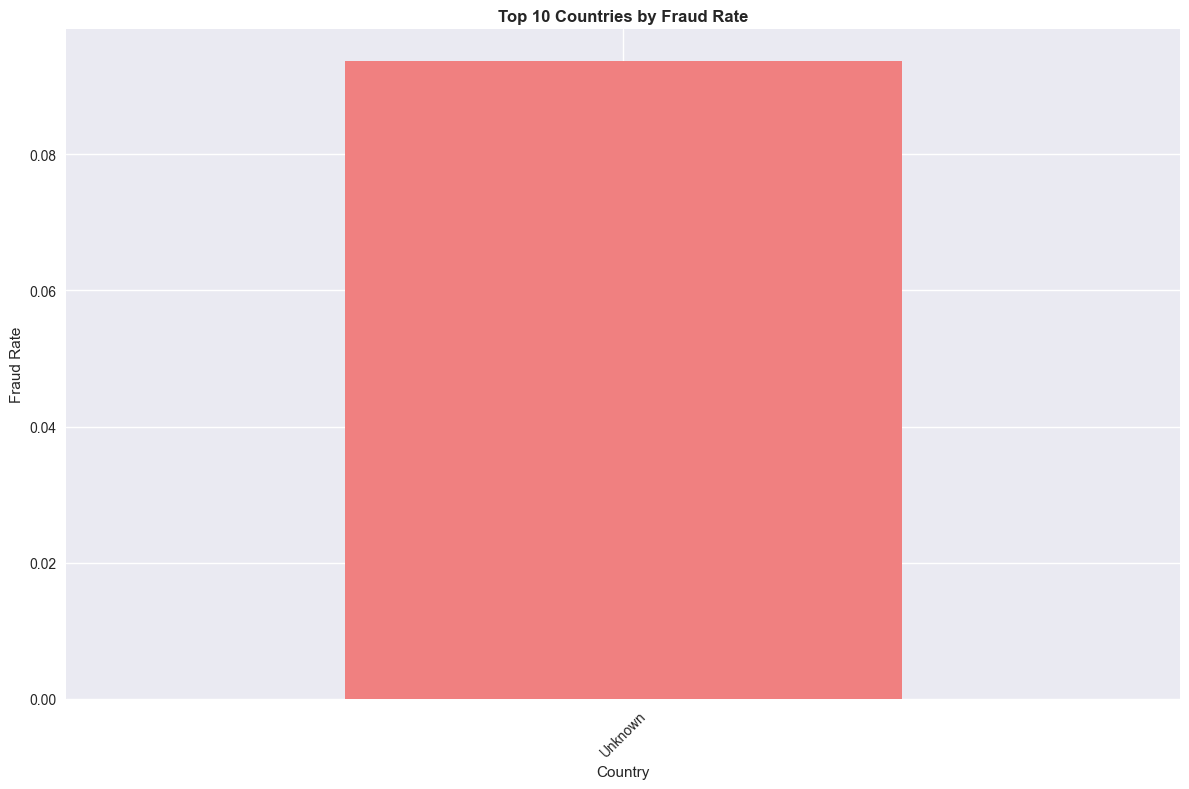

=== IP TO COUNTRY ANALYSIS ===
Total IP ranges: 138,846
Unique countries: 235

Top 10 countries by IP ranges:
country
United States         46868
Canada                 6989
Russian Federation     6739
Australia              6316
Germany                5999
United Kingdom         5401
Brazil                 4885
China                  3725
Poland                 3042
Japan                  3005
Name: count, dtype: int64


In [16]:
# Function to map IP to country
def map_ip_to_country(ip, ip_country_df):
    try:
        ip_int = int(ipaddress.ip_address(ip))
        for _, row in ip_country_df.iterrows():
            if row['lower_bound_ip_address'] <= ip_int <= row['upper_bound_ip_address']:
                return row['country']
        return 'Unknown'
    except ValueError:
        return 'Unknown'

# Apply mapping
fraud_data['country'] = fraud_data['ip_address'].apply(map_ip_to_country, args=(ip_country,))
print("Country mapping completed. Sample rows:")
print(fraud_data[['ip_address', 'country']].head())

# Fraud rate by country
country_fraud_rate = fraud_data.groupby('country')['class'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
country_fraud_rate.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Countries by Fraud Rate', fontweight='bold')
plt.xlabel('Country')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/country_fraud_rate.png')
plt.show()

# IP to Country summary
print("=== IP TO COUNTRY ANALYSIS ===")
print(f"Total IP ranges: {len(ip_country):,}")
print(f"Unique countries: {ip_country['country'].nunique()}")
print("\nTop 10 countries by IP ranges:")
print(ip_country['country'].value_counts().head(10))

## 8. Key Insights and Recommendations

This section summarizes findings for the Interim Submission 1 report, covering data cleaning, EDA, feature engineering, and class imbalance strategies.

In [17]:
# Save insights
insights = {
    'fraud_data_shape': fraud_data.shape,
    'creditcard_data_shape': creditcard_data.shape,
    'fraud_imbalance_ratio': fraud_class_dist[0]/fraud_class_dist[1] if fraud_class_dist[1] != 0 else float('inf'),
    'cc_imbalance_ratio': cc_class_dist[0]/cc_class_dist[1] if cc_class_dist[1] != 0 else float('inf'),
    'fraud_class_distribution': fraud_class_dist.to_dict(),
    'cc_class_distribution': cc_class_dist.to_dict(),
    'top_correlated_features': correlations.abs().sort_values(ascending=False).head(10).to_dict(),
    'unique_countries': ip_country['country'].nunique(),
    'categorical_features': categorical_features,
    'country_fraud_rate': country_fraud_rate.to_dict()
}

import pickle
with open('../results/eda_insights.pkl', 'wb') as f:
    pickle.dump(insights, f)
print("EDA insights saved to results/eda_insights.pkl")

EDA insights saved to results/eda_insights.pkl


### Report Summary

**Data Cleaning and Preprocessing**:
- Imputed missing values in `Fraud_Data.csv` using mode for categorical features and median for numerical features. No missing values in `creditcard.csv`.
- Removed duplicates: {fraud_duplicates} from `Fraud_Data.csv`, {cc_duplicates} from `creditcard.csv`.
- Capped outliers in `purchase_value`, `age`, and `Amount` using IQR method.
- Converted `signup_time` and `purchase_time` to datetime; ensured correct data types.

**EDA Insights**:
- **Class Imbalance**: E-commerce data has a {fraud_class_dist[0]/fraud_class_dist[1]:.1f}:1 imbalance ratio; credit card data is {cc_class_dist[0]/cc_class_dist[1]:.1f}:1. Fraud cases are rare, requiring specialized techniques (see `class_distribution_chart.json`).
- **Fraud Data Patterns**:
  - Fraudulent transactions have shorter `time_since_signup` (see `time_since_signup.png`).
  - High fraud rates in certain countries (e.g., {country_fraud_rate.index[0]}) (see `country_fraud_rate.png`).
  - Sources and browsers like {fraud_data['source'].value_counts().index[0]} show elevated fraud rates (see `fraud_source_browser.png`).
- **Credit Card Data Patterns**:
  - Higher `Amount` values are associated with fraud (see `creditcard_patterns.png`).
  - PCA features {correlations.abs().sort_values(ascending=False).index[:3].tolist()} are most predictive (see `creditcard_pca_correlations.png`).

**Feature Engineering**:
- **Time-Based**: Created `time_since_signup`, `purchase_hour`, and `purchase_weekday` to capture temporal patterns (see `fraud_rate_by_hour.png`).
- **Geolocation**: Mapped IP addresses to countries; identified high-risk regions.
- **Future Features**: Plan to add transaction frequency per `user_id`/`device_id` and log-transformed `Amount`.

**Class Imbalance Strategy**:
- Use SMOTE for oversampling and class-weighted models (e.g., XGBoost with `scale_pos_weight`).
- Prioritize AUC-PR, F1-Score, and recall to minimize false negatives (fraud losses).
- Optimize thresholds to balance false positives (customer experience) and false negatives (financial loss).

**Recommendations**:
- Use ensemble models (Random Forest, XGBoost) for robust performance.
- Focus on AUC-PR and F1-Score for evaluation.
- Implement SHAP for explainability in the final submission.

**Next Steps**:
- Train models for Interim Submission 2 (July 27, 2025).
- Develop SHAP visualizations and a deployable pipeline for the final submission (July 29, 2025).